In [44]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch

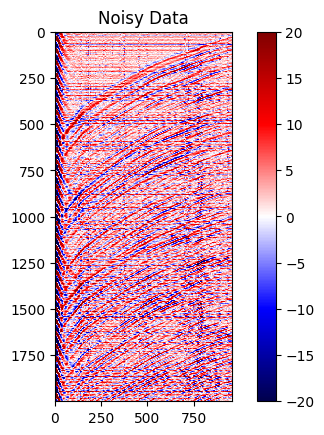

In [46]:
data = np.load('data/DAS/eq-36.npy')

y = data.T

plt.imshow(y, cmap='seismic', vmin=-20, vmax=20)
plt.title('Noisy Data')
plt.colorbar()
plt.show()

y = torch.Tensor(y).unsqueeze(0).unsqueeze(0)

In [47]:
from models import UNetModECA, FC_ECA
from denoisers.dip import DIP, SGDIP, PatchDIP, losses, schedules
# architectures
net1 = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=4)
net2 = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=2)
net3 = FC_ECA(16*16)

# schedules
linear = schedules.Linear(1, 10)

# losses
mse = losses.MSE()
mse_ae = losses.Composed(losses.Composed(mse, losses.TV()), losses.AE(), linear)
mse_tv = losses.Composed(mse, losses.TV())
nmse = losses.NMSE()

# variants
# dip = SGDIP(net1, mse_ae)
# dip = DIP(net1, mse_tv, max_epochs=100)
dip = PatchDIP(net2, mse, 20, batch_size=1024, kurtosis_threshold=0, use_diff=True)

options = {
    "mode": "local",
    "config": {
        "project": "",
        "entity": "",
        "group": "",
        "dataset": "",
        "denoiser_id": 0,
        "data_id": 0,
    },
    "metrics": {},
    "log_output": False,
}
x_hat = dip.denoise(y, logging_options=options)
x_hat = x_hat.detach().clone().cpu()

Running: 0 - PatchDIP (epochs=20) - MSE - UNetMod ECA 


100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Summary: {'runtime': '00:01:57'}



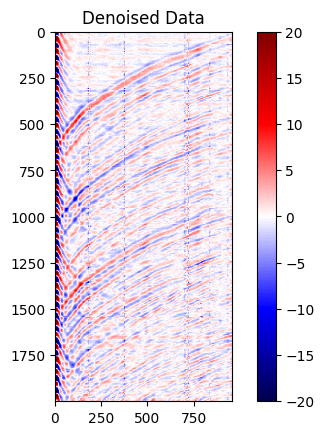

In [48]:
plt.imshow(x_hat.squeeze().numpy(), cmap='seismic', vmin=-20, vmax=20)
plt.title('Denoised Data')
plt.colorbar()
plt.show()

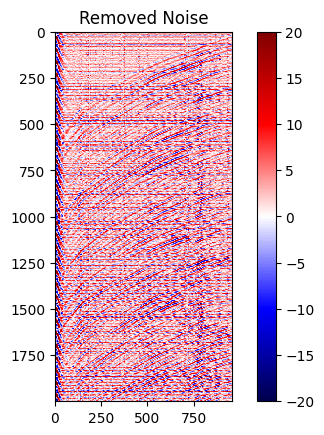

In [49]:
diff = y - x_hat

# diff[diff.abs() < 10] = 0

plt.imshow(diff.squeeze().numpy(), cmap='seismic', vmin=-20, vmax=20)
plt.title('Removed Noise')
plt.colorbar()
plt.show()

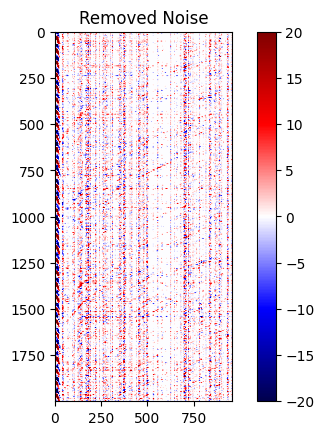

In [50]:
y_ = y.clone()

y_[y.abs() < 40] = 0

plt.imshow(y_.squeeze().numpy(), cmap='seismic', vmin=-20, vmax=20)
plt.title('Removed Noise')
plt.colorbar()